# AG3 - Actividad Guiada 3

Nombre: Carlos Javier Bravo Intriago

Link:   https://colab.research.google.com/drive/1KJYOEgvLdYHFngyX9lAbgp-pwRASvd-Y?usp=sharing

Github: https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025/tree/main/AG3



# Carga de librerias

In [1]:
from typing import List, Tuple, Union

import numpy as np
!pip install requests
!pip install tabulate>=0.9 networkx>=3.0
!pip install tsplib95 --no-deps
!pip install deprecated


[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip


# Importe de librerias

In [2]:
import gzip
import math  # Módulo de funciones matemáticas. Se usa para exp
import os
import random  # Para generar valores aleatorios
import shutil
import urllib.request  # Hacer llamadas http a páginas de la red

import tsplib95  # Módulo para las instancias del problema del TSP

## Métodos Auxiliares y algunas definiciones necesarias

In [3]:
NumericType = Union[int, float]
NodeType = int
EdgeType = Tuple[NodeType, NodeType]
SolutionType = List[NodeType]
TSProblemType = tsplib95.models.Problem

def download_tsp_file(url: str, filename: str) -> None:
    local_path, headers = urllib.request.urlretrieve(url, filename + ".temp")
    mime_type = headers.get_content_type()
    if "gzip" in mime_type or local_path.endswith(".gz"):
        with gzip.open(local_path, 'rb') as f_in:
            with open(filename, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        os.remove(local_path)
    else:
        os.replace(local_path, filename)

# Carga de los datos del problema

Documentación :
* https://web.archive.org/web/http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/
* https://web.archive.org/web/http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf
* https://tsplib95.readthedocs.io/en/stable/pages/usage.html
* https://tsplib95.readthedocs.io/en/v0.6.1/modules.html
* https://pypi.org/project/tsplib95/
* https://github.com/mastqe/tsplib/tree/master

In [4]:
#Descargamos el fichero de datos(Matriz de distancias)

# Matriz Adyacencia swiss42 problem (Staedte Schweiz/Fricker)
file = "swiss42.tsp"
download_tsp_file("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/swiss42.tsp", file)

# Coordenadas Euclidianas 51-city problem (Christofides/Eilon)
# file = "eil51.tsp"
# download_tsp_file("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/eil51.tsp", file)

# Coordenadas Euclidianas - 48 capitals of the US (Padberg/Rinaldi)
# file = "att48.tsp"
# download_tsp_file("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/att48.tsp", file)

_Carga de datos y generación de objeto problem_

In [5]:
problem: tsplib95.models.Problem = tsplib95.load(file)

nodes: List[NodeType] = list(problem.get_nodes())
edges: List[EdgeType] = list(problem.get_edges())


<div style="flex: 0 0 300px; text-align: center;">
        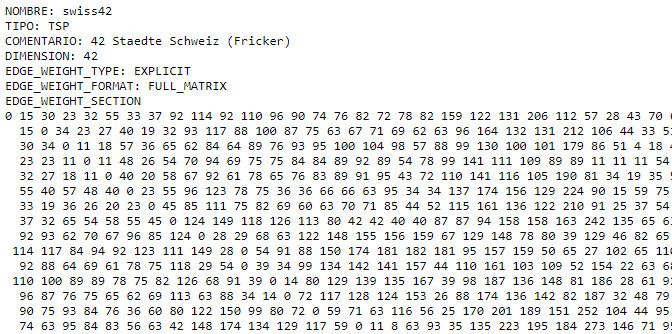
        <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 1. Visualizacion del problema swiss.42.tsp</p>
    </div>
</div>


Probamos algunas funciones del objeto problem
Distancia entre nodos

In [6]:
problem.get_weight(4, 0)

32

_Para ver todas las funciones, véase la documentación: https://tsplib95.readthedocs.io/en/v0.6.1/modules.html_

# Funcionas básicas

In [7]:
def crear_solucion(nodos: List[NodeType]) -> SolutionType:
    """
    Se genera una solución aleatoria con comienzo en el nodo 0
    :param nodos: Lista de nodos
    :return: Lista de nodos en posiciones aleatorias sin repetición
    """
    solucion = [nodos[0]]
    for _ in nodos[1:]:
        solucion = solucion + [
            random.choice(list(set(nodos) - {nodos[0]} - set(solucion)))]
    return solucion

def distancia(a: int, b: int, problem: TSProblemType) -> NumericType:
    """
    Devuelve la distancia entre dos nodos
    :param a: Nodo a
    :param b: Nodo b
    :param problem: Instancia de tsplib95.models.Problem
    :return:
    """
    return problem.get_weight(a, b)

def distancia_total(solucion: List[int], problem: TSProblemType) -> NumericType:
    """
    Devuelve la distancia total de una trayectoria/solución
    :param solucion: Lista de Nodos
    :param problem: Instancia de tsplib95.models.Problem
    :return:
    """
    distancia_total = 0
    for i in range(len(solucion) - 1):
        distancia_total += distancia(solucion[i], solucion[i + 1], problem)
    return distancia_total + distancia(solucion[len(solucion) - 1], solucion[0], problem)


sol_temporal = crear_solucion(nodes)

print(sol_temporal)
print(distancia_total(sol_temporal, problem))

[0, 15, 34, 24, 6, 32, 39, 18, 30, 8, 23, 17, 29, 14, 5, 37, 22, 7, 11, 41, 16, 2, 3, 20, 1, 38, 13, 35, 28, 10, 19, 21, 12, 36, 40, 25, 9, 31, 4, 26, 33, 27]
5307


# BÚSQUEDA ALEATORIA

In [8]:
def busqueda_aleatoria(problem: TSProblemType, n: int) -> SolutionType:
    """
    Busca de manera aleatoria en N iteraciones alguna mejor solución.
    :param problem: Instancia de tsplib95.models.Problem
    :param n: el número de iteraciones
    :return:
    """
    nodos = list(problem.get_nodes())
    mejor_solucion = []
    #Inicializamos con un valor alto
    mejor_distancia = float('inf')
    #Criterio de parada: repetir N veces pero podemos incluir otros
    for i in range(n):
        solucion = crear_solucion(nodos)  #Genera una solucion aleatoria
        distancia = distancia_total(solucion, problem)  #Calcula el valor objetivo(distancia total)
        if distancia < mejor_distancia:  #Compara con la mejor obtenida hasta ahora
            mejor_solucion = solucion
            mejor_distancia = distancia

    print("Mejor solución:", mejor_solucion)
    print("Distancia     :", mejor_distancia)
    return mejor_solucion

#Busqueda aleatoria con 50000 iteraciones
solucion = busqueda_aleatoria(problem, 50000)

Mejor solución: [0, 6, 19, 20, 10, 41, 23, 34, 32, 2, 26, 12, 9, 25, 8, 30, 28, 33, 31, 13, 5, 37, 16, 4, 36, 17, 14, 35, 18, 7, 29, 1, 27, 22, 39, 40, 21, 11, 15, 3, 24, 38]
Distancia     : 3602


# BÚSQUEDA LOCAL

In [9]:
def generar_vecina(solucion: SolutionType) -> SolutionType:
    """
    Generador de soluciones vecinas: 2-opt (intercambiar 2 nodos) Si hay N
    nodos se generan (N-1)x(N-2)/2 soluciones.\n
    Se puede modificar para aplicar otros generadores distintos que 2-opt
    :param solucion: Lista de nodos
    :return:
    """
    mejor_solucion = []
    mejor_distancia = 10e100
    #Recorremos todos los nodos en bucle doble para evaluar todos los intercambios 2-opt
    for i in range(1, len(solucion) - 1):
        for j in range(i + 1, len(solucion)):
            # Se genera una nueva solución intercambiando los dos nodos i,j:
            # (usamos el operador + que para listas en python las concatena) : ej.: [1,2] + [3] = [1,2,3]
            vecina = solucion[:i] + [solucion[j]] + solucion[i + 1:j] + [solucion[i]] + solucion[j + 1:]

            # Se evalúa la nueva solución ...
            distancia_vecina = distancia_total(vecina, problem)
            # ... para guardarla si mejora las anteriores
            if distancia_vecina <= mejor_distancia:
                mejor_distancia = distancia_vecina
                mejor_solucion = vecina
    return mejor_solucion


# solucion = [1, 47, 13, 41, 40, 19, 42, 44, 37, 5, 22, 28, 3, 2, 29, 21, 50, 34, 30, 9, 16, 11, 38, 49, 10, 39, 33, 45, 15, 24, 43, 26, 31, 36, 35, 20, 8, 7, 23, 48, 27, 12, 17, 4, 18, 25, 14, 6, 51, 46, 32]
print("Distancia Solucion Incial:", distancia_total(solucion, problem))

nueva_solucion = generar_vecina(solucion)
print("Distancia Mejor Solucion Local:",
      distancia_total(nueva_solucion, problem))


Distancia Solucion Incial: 3602
Distancia Mejor Solucion Local: 3294


# Búsqueda Local(iteraciones):

In [10]:
def busqueda_local(
        solucion: SolutionType,
        problem: TSProblemType
) -> SolutionType:
    """
    Búsqueda Local(iteraciones):\n
    * Sobre el operador de vecindad 2-opt(función generar_vecina)\n
    * Sin criterio de parada, se para cuando no es posible mejorar.
    :param solucion:
    :param problem:
    :return:
    """
    mejor_solucion = []

    #Generar una solucion inicial de referencia(aleatoria)
    #solucion_referencia = crear_solucion(Nodos)
    solucion_referencia = solucion
    mejor_distancia = distancia_total(solucion_referencia, problem)

    iteracion = 0  # Un contador para saber las iteraciones que hacemos
    while True:
        iteracion += 1  # Incrementamos el contador

        # Obtenemos la mejor vecina ...
        vecina = generar_vecina(solucion_referencia)
        # ... y la evaluamos para ver si mejoramos respecto a lo encontrado
        # hasta el momento
        distancia_vecina = distancia_total(vecina, problem)

        # Si no mejoramos hay que terminar. Hemos llegado a un minimo local
        # (según nuestro operador de vecindad 2-opt)
        if distancia_vecina < mejor_distancia:
            # mejor_solucion = copy.deepcopy(vecina)
            mejor_solucion = vecina  #Guarda la mejor solución encontrada
            mejor_distancia = distancia_vecina

        else:
            print(
                "En la iteración ", iteracion,
                ", la mejor solución encontrada es:", mejor_solucion
            )
            print("Distancia     :", mejor_distancia)
            return mejor_solucion

        solucion_referencia = vecina


sol = busqueda_local(nueva_solucion, problem)

En la iteración  21 , la mejor solución encontrada es: [0, 6, 5, 26, 10, 41, 23, 28, 27, 2, 18, 12, 11, 25, 4, 3, 1, 31, 7, 13, 19, 14, 16, 15, 37, 17, 36, 35, 20, 33, 34, 32, 30, 39, 24, 40, 21, 9, 8, 29, 22, 38]
Distancia     : 1773


# SIMULATED ANNEALING

In [11]:
def genera_vecina_aleatorio(solucion: SolutionType) -> SolutionType:
    """
    Generador de 1 solución vecina 2-opt 100% aleatoria (intercambiar 2 nodos)\n
    Mejorable eligiendo otra forma de elegir una vecina.
    :param solucion:
    :return:
    """
    #Se eligen dos nodos aleatoriamente
    i, j = sorted(random.sample(range(1, len(solucion)), 2))

    #Devuelve una nueva solución pero intercambiando los dos nodos elegidos al azar
    return solucion[:i] + [solucion[j]] + solucion[i + 1:j] + [
        solucion[i]] + solucion[j + 1:]


def probabilidad(T: float, d: float) -> bool:
    """
    Función de probabilidad para aceptar peores soluciones
    :param T: Temperatura
    :param d:
    :return:
    """
    if random.random() < math.exp(-1 * d / T):
        return True
    else:
        return False


def bajar_temperatura(T: float) -> float:
    """
    Funcion de descenso de temperatura
    :param T: Temperatura
    :return:
    """
    return T * 0.99

In [12]:
def recocido_simulado(
        problem: TSProblemType,
        TEMPERATURA: float
) -> SolutionType:
    #problem = datos del problema
    #T = Temperatura

    solucion_referencia = crear_solucion(nodes)
    distancia_referencia = distancia_total(solucion_referencia, problem)

    mejor_solucion = []  #x* del seudocodigo
    mejor_distancia = 10e100  #F* del seudocodigo

    N = 0
    while TEMPERATURA > .0001:
        N += 1
        #Genera una solución vecina
        vecina = genera_vecina_aleatorio(solucion_referencia)

        #Calcula su valor(distancia)
        distancia_vecina = distancia_total(vecina, problem)

        #Si es la mejor solución de todas se guarda(siempre!!!)
        if distancia_vecina < mejor_distancia:
            mejor_solucion = vecina
            mejor_distancia = distancia_vecina

        #Si la nueva vecina es mejor se cambia
        #Si es peor se cambia según una probabilidad que depende de T y delta
        # (distancia_referencia - distancia_vecina)
        if distancia_vecina < distancia_referencia \
                or probabilidad(TEMPERATURA, abs(distancia_referencia - distancia_vecina)):
            #solucion_referencia = copy.deepcopy(vecina)
            solucion_referencia = vecina
            distancia_referencia = distancia_vecina

        #Bajamos la temperatura
        TEMPERATURA = bajar_temperatura(TEMPERATURA)

    print("La mejor solución encontrada es ", end="")
    print(mejor_solucion)
    print("con una distancia total de ", end="")
    print(mejor_distancia)
    return mejor_solucion


sol = recocido_simulado(problem, 10000000)

La mejor solución encontrada es [0, 27, 2, 28, 39, 24, 40, 41, 25, 11, 12, 18, 26, 23, 21, 22, 38, 33, 20, 34, 30, 9, 8, 10, 29, 17, 31, 35, 36, 19, 13, 16, 14, 15, 37, 7, 1, 6, 5, 4, 3, 32]
con una distancia total de 1925


Representación en un grafo a partir de la matriz de distancias (Optimización de posiciones usando escalado multidimensional (MDS)



Multidimensional scaling problem(MDS):   https://en.wikipedia.org/wiki/Multidimensional_scaling

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import MDS  # Multidimensional Scaling o Escalado Multidimensional


def plot_tsp_solution(
        distance_matrix: np.ndarray,
        tsp_solution: SolutionType
) -> None:
    """
    Dibuja el grafo de un TSP con las posiciones calculadas mediante MDS y muestra
    solo las aristas correspondientes a la solución del TSP.

    :param distance_matrix: np.ndarray, matriz de distancias entre nodos
    :param tsp_solution: list, lista de nodos en el orden de la solución del TSP
    """
    # Crear el grafo completo
    G = nx.Graph()
    num_nodes = len(distance_matrix)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            G.add_edge(i, j, weight=distance_matrix[i][j])

    # Usar MDS para calcular posiciones de los nodos
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    positions = mds.fit_transform(distance_matrix)

    # Convertir las posiciones en un diccionario para networkx
    pos = {i: positions[i] for i in range(num_nodes)}

    # Crear un subgrafo con las aristas del camino TSP
    TSP_G = nx.Graph()
    for i in range(len(tsp_solution) - 1):
        u = tsp_solution[i]
        v = tsp_solution[i + 1]
        TSP_G.add_edge(u, v, weight=distance_matrix[u][v])

    # Dibujar el grafo
    plt.figure(figsize=(8, 6))

    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)

    # Dibujar las aristas del camino TSP
    nx.draw_networkx_edges(TSP_G, pos, edge_color='red', width=2)

    # Añadir etiquetas a los nodos y pesos de las aristas
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(TSP_G, 'weight')
    nx.draw_networkx_edge_labels(TSP_G, pos, edge_labels=edge_labels,
                                 font_size=8)

    plt.title("Grafo TSP con solución específica")
    plt.show()


/home/carlos/03MIAR-Algoritmos-de-Optimizacion-2025/venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


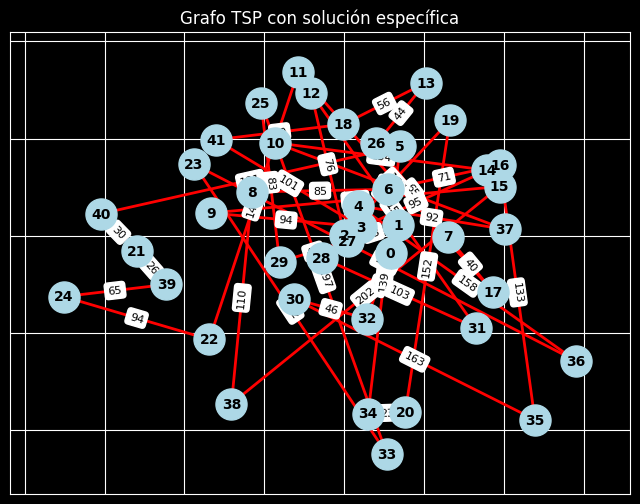

In [14]:
plot_tsp_solution(problem.edge_weights, crear_solucion(nodes))

/home/carlos/03MIAR-Algoritmos-de-Optimizacion-2025/venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


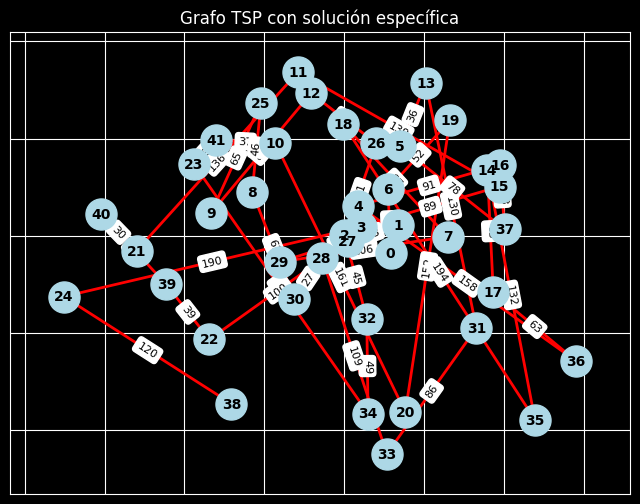

In [15]:
plot_tsp_solution(problem.edge_weights, solucion)